<a href="https://colab.research.google.com/github/SimonCreater/Cuda_Coding/blob/main/buildingDetectionwithUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.11.0 # Install a compatible TensorFlow version

In [ ]:
!pip install segment-geospatial

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout
# from tensorflow.keras.models import load_model
# from sklearn.model_selection import KFold
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.models import Model

In [ ]:
# connect google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
os.chdir(r'/content/gdrive/MyDrive/archive (2)')

In [ ]:

train_x = sorted(glob.glob('train/*_image.tif'))
train_y = sorted(glob.glob('train/*_label.tif'))
test_x = sorted(glob.glob('test/*_image.tif'))
test_y = sorted(glob.glob('test/*_label.tif'))

print(len(train_x), len(test_x))

70 30


In [ ]:
train_xx = np.zeros((70, 128, 128, 3))
train_yy = np.zeros((70, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):
  # if i == 1:
  #   break

  img = Image.open(img)
  np_img = np.array(img)
  train_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  train_yy[i] = np_mask
  print(train_yy[i])

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [1.]
  [1.]
  [1.]]

 [[0.]
  [0.]
  [0.]
  ...
  [1.]
  [1.]
  [1.]]

 [[0.]
  [0.]
  [0.]
  ...
  [1.]
  [1.]
  [1.]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[0.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [1.]
  ...
  [0.

In [ ]:
test_xx = np.zeros((30, 128, 128, 3))
test_yy = np.zeros((30, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_x, test_y)):

  img = Image.open(img)
  np_img = np.array(img)
  test_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  test_yy[i] = np_mask

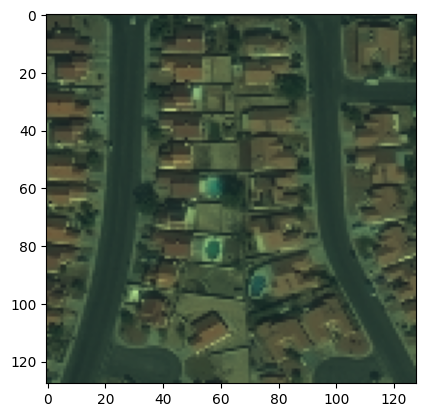

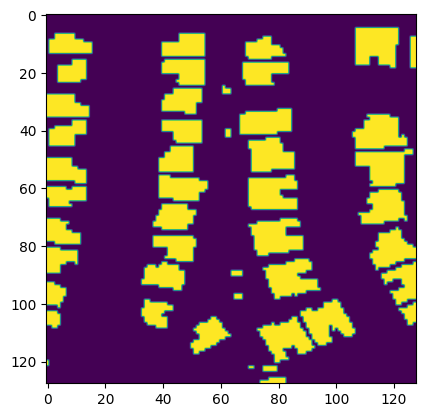

In [ ]:
plt.imshow(train_xx[10, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[10, :, :, 0].astype('uint8'))
plt.show()

In [ ]:
np.save('train_xx.npy', train_xx)
np.save('train_yy.npy', train_yy)
np.save("test_xx.npy", test_xx)
np.save("test_yy.npy", test_yy)

In [ ]:
x_in = Input(shape=(128, 128, 3))


x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)


x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)


x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

# 첫 번쨰 model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(
    loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy']
)
# 세 번째 model.compile(
#     loss='mean_squared_error',  optimizer='adam', metrics=['accuracy']
# )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=100, batch_size=10, verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 297ms/step - loss: 0.7951 - accuracy: 0.7021 - val_loss: 0.6257 - val_accuracy: 0.7712
Epoch 2/100
7/7 [==============================] - 2s 249ms/step - loss: 0.5875 - accuracy: 0.7754 - val_loss: 0.5766 - val_accuracy: 0.7693
Epoch 3/100
7/7 [==============================] - 2s 248ms/step - loss: 0.5446 - accuracy: 0.7848 - val_loss: 0.4863 - val_accuracy: 0.7736
Epoch 4/100
7/7 [==============================] - 2s 245ms/step - loss: 0.5146 - accuracy: 0.7910 - val_loss: 0.4208 - val_accuracy: 0.8370
Epoch 5/100
7/7 [==============================] - 2s 254ms/step - loss: 0.4726 - accuracy: 0.8048 - val_loss: 0.4446 - val_accuracy: 0.8061
Epoch 6/100
7/7 [==============================] - 2s 261ms/step - loss: 0.4620 - accuracy: 0.8082 - val_loss: 0.3973 - val_accuracy: 0.8347
Epoch 7/100
7/7 [==============================] - 2s 251ms/step - loss: 0.4562 - accuracy: 0.8142 - val_loss: 0.4021 - val_accuracy: 0.8388
Epoch 8/100
7

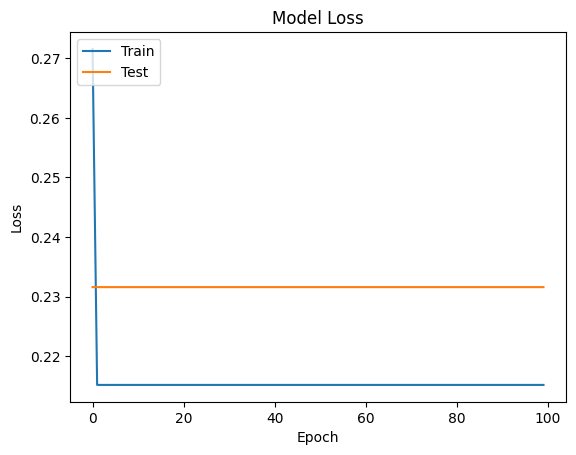

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

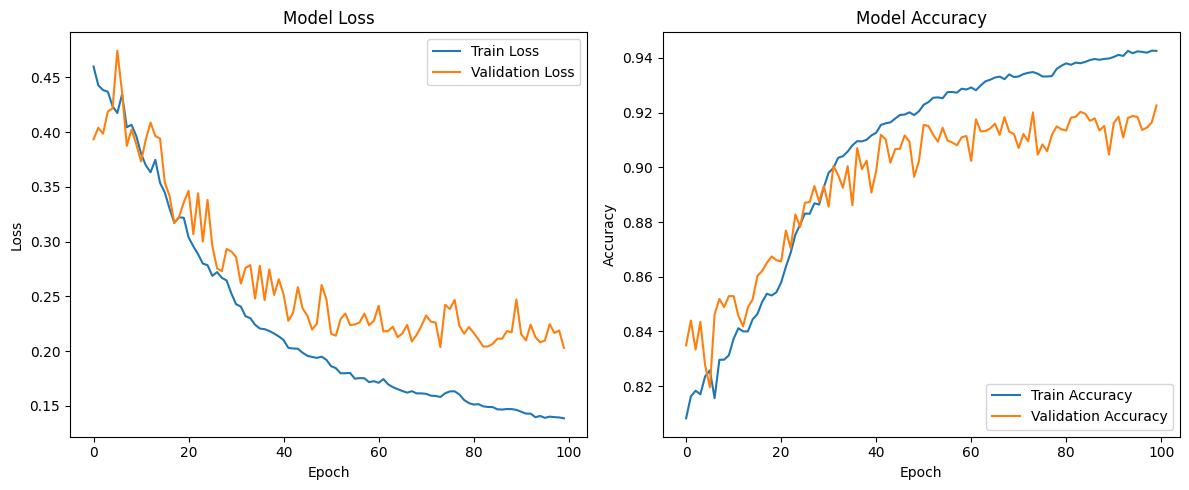

In [ ]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [ ]:
model.save('/content/gdrive/MyDrive/my_modelbinary_crossentropy.h5')

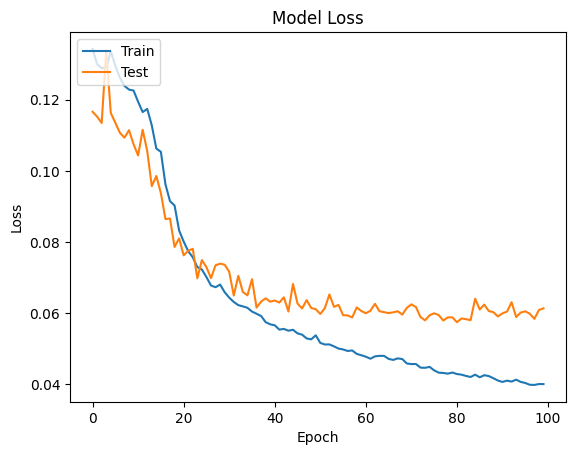

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model


model = load_model('/content/gdrive/MyDrive/my_modelbinary_crossentropy.h5')

model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_99 (Conv2D)             (None, 128, 128, 32  896         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_72 (Dropout)           (None, 128, 128, 32  0           ['conv2d_99[0][0]']              
                                )                                                           

1/1 [==============================] - 0s 197ms/step
(30, 128, 128, 1)


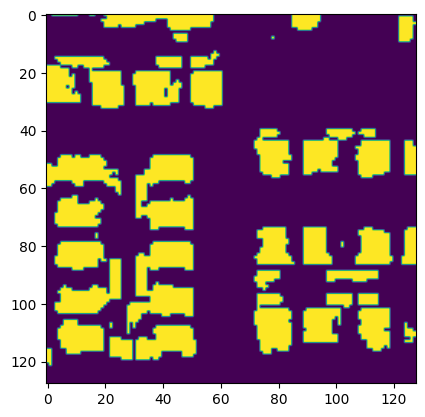

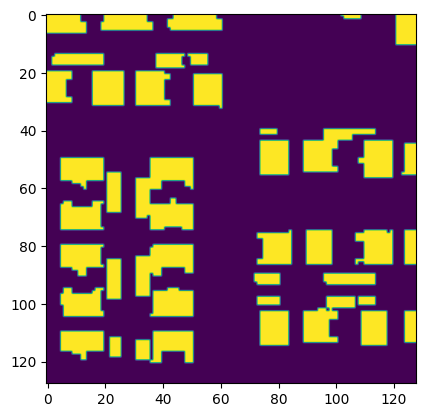

In [ ]:
threshold = 0.5

# prediction of the output
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's comare random predicted and actial y values
plt.imshow(pred_test[12, :, :, 0])
plt.show()
plt.imshow(test_yy[12,:,:,0])
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_xx, test_yy, batch_size=10)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

3/3 [==============================] - 1s 285ms/step - loss: 1.2483 - accuracy: 0.7684
Loss: 1.2482757568359375
Accuracy: 0.76837158203125


In [ ]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

In [ ]:
m = leafmap.Map(center=[37.4501, 126.6538], zoom=22, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[37.4501, 126.6538], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [ ]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-122.2659, 37.8682, -122.2521, 37.8741]

In [ ]:
image = "satellite.tif3"
tms_to_geotiff(output=image, bbox=bbox, zoom=20, source="Satellite", overwrite=True)

Downloaded image 01/36
Downloaded image 02/36
Downloaded image 03/36
Downloaded image 04/36
Downloaded image 05/36
Downloaded image 06/36
Downloaded image 07/36
Downloaded image 08/36
Downloaded image 09/36
Downloaded image 10/36
Downloaded image 11/36
Downloaded image 12/36
Downloaded image 13/36
Downloaded image 14/36
Downloaded image 15/36
Downloaded image 16/36
Downloaded image 17/36
Downloaded image 18/36
Downloaded image 19/36
Downloaded image 20/36
Downloaded image 21/36
Downloaded image 22/36
Downloaded image 23/36
Downloaded image 24/36
Downloaded image 25/36
Downloaded image 26/36
Downloaded image 27/36
Downloaded image 28/36
Downloaded image 29/36
Downloaded image 30/36
Downloaded image 31/36
Downloaded image 32/36
Downloaded image 33/36
Downloaded image 34/36
Downloaded image 35/36
Downloaded image 36/36
Saving GeoTIFF. Please wait...
Image saved to satellite.tif3


In [ ]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=6504058.0, center=[37.45195, 126.65385], controls=(ZoomControl(options=['position', 'zoom_in_text',…